In [40]:
IMAGE_SIZE = 64
CLASSES = ['3001', '3003', '3004', '3005', '3006', '3007', '3008', '3010', '3020', '3021', '3022', '3023', '3024']

In [41]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
try:
    API_KEY = os.environ["REBRICKABLE_API_KEY"]
except:
    print('Please add your Rebrickable API Key to the project as instructed in the README.')

In [42]:
import os
import cv2
import pandas as pd
import torch
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import tqdm
import requests as r

class LegoDataset(Dataset):
    def __init__(self, dataset_path, transform=transforms.Compose([transforms.ToPILImage(), 
                                               transforms.Grayscale(num_output_channels=3),
                                               transforms.ToTensor()])):

        # Init output data
        x_data = []
        y_data = []
        labels = []

        encoding = { 'woohoo!': -1 }
        
        # For each class folder
        for label in os.listdir(dataset_path):

            # Only account for certain classes, ignore others
            if label in CLASSES:

                # Initialize variables to retrieve and store images
                curr_path = dataset_path + "/" + label

                # For each image
                for filename in tqdm.tqdm(os.listdir(curr_path)):

                    # Store image in tensor representation
                    image_path = curr_path + "/" + filename
                    img = cv2.imread(image_path)
                    img = transform(img)
                    # img = cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC)

                    # Add tensor to data dictionary
                    x_data.append(img.float())
                    if label not in encoding:
                        encoding[label] = max(list(encoding.values())) + 1
                    y_data.append(encoding[label])
                    labels.append(label)

        self.x_data = x_data
        self.y_data = y_data
        self.labels = set(labels)
        self.encoding = encoding

        rebrickable_query = 'https://rebrickable.com/api/v3/lego/parts/?key=' + API_KEY + '&part_nums='
        for label in self.labels:
            rebrickable_query += label + ','

        self.brick_info = {}
        response = r.get(rebrickable_query).json()
        for entry in response['results']:
            self.brick_info[entry['part_num']] = entry

        self.brick_info = pd.DataFrame(self.brick_info).T

    def __len__(self):
        assert len(self.x_data) == len(self.y_data)
        return len(self.x_data)

    def __getitem__(self, idx):
        return (self.x_data[idx], self.y_data[idx])

In [43]:
dataset = LegoDataset('dataset')

100%|██████████| 4000/4000 [00:02<00:00, 1622.24it/s]


In [44]:
dataset.brick_info

,part_num,name,part_cat_id,part_url,part_img_url,external_ids,print_of
3001,3001,Brick 2 x 4,11,https://rebrickable.com/parts/3001/brick-2-x-4/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3001'], 'BrickOwl': ['771344']...",None
3003,3003,Brick 2 x 2,11,https://rebrickable.com/parts/3003/brick-2-x-2/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3003'], 'BrickOwl': ['3003', '...",None
3004,3004,Brick 1 x 2,11,https://rebrickable.com/parts/3004/brick-1-x-2/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3004'], 'BrickOwl': ['442413']...",None
3005,3005,Brick 1 x 1,11,https://rebrickable.com/parts/3005/brick-1-x-1/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3005'], 'BrickOwl': ['656416']...",None
3008,3008,Brick 1 x 8,11,https://rebrickable.com/parts/3008/brick-1-x-8/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3008'], 'BrickOwl': ['273019']...",None
3010,3010,Brick 1 x 4,11,https://rebrickable.com/parts/3010/brick-1-x-4/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3010'], 'BrickOwl': ['752369']...",None
3020,3020,Plate 2 x 4,14,https://rebrickable.com/parts/3020/plate-2-x-4/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3020'], 'BrickOwl': ['80025'],...",None
3021,3021,Plate 2 x 3,14,https://rebrickable.com/parts/3021/plate-2-x-3/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3021'], 'BrickOwl': ['960521']...",None
3022,3022,Plate 2 x 2,14,https://rebrickable.com/parts/3022/plate-2-x-2/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3022'], 'BrickOwl': ['566026']...",None
3023,3023,Plate 1 x 2,14,https://rebrickable.com/parts/3023/plate-1-x-2/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3023'], 'BrickOwl': ['44980'],...",None


In [45]:
import math
import torch.utils.data
from torch.utils.data import DataLoader
train_data, test_data = torch.utils.data.random_split(dataset, [math.floor(len(dataset) * 0.8), math.ceil(len(dataset) * 0.2)])
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)

Feature batch shape: torch.Size([20, 3, 64, 64])
Labels batch shape: torch.Size([20])


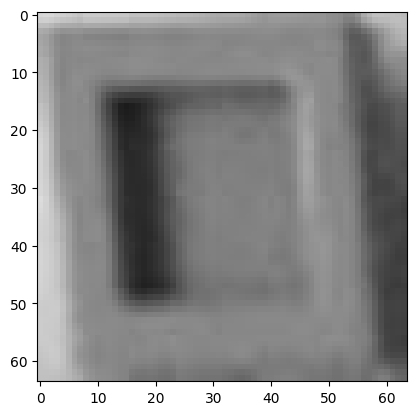

Label: 10


In [46]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1024, 1024)  # 5*5 from image dimension
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, len(CLASSES))
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 3)
        x = F.max_pool2d(F.relu(self.conv2(x)), 3)
        x = F.max_pool2d(F.relu(self.conv3(x)), 1)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [48]:
net = Net().cpu()

In [49]:
from torchvision import datasets, models, transforms
from torchvision.models import EfficientNet_V2_L_Weights

model_ft = models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.fc = nn.Linear(1000, len(CLASSES), 1)
model_ft.fc.requires_grad_ = True
model_ft

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [51]:
loss_over_time = []
val_accuracy_over_time = []

In [52]:
for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            loss_over_time.append(running_loss)
            running_loss = 0.0

    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = net(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_accuracy_over_time.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

[1,   100] loss: 25.596
[1,   200] loss: 25.411
[1,   300] loss: 25.250
[1,   400] loss: 25.156
[1,   500] loss: 24.985
[1,   600] loss: 24.876
[1,   700] loss: 24.803
[1,   800] loss: 24.709
[1,   900] loss: 24.494
[1,  1000] loss: 24.410
[1,  1100] loss: 24.097
[1,  1200] loss: 24.114
[1,  1300] loss: 24.043
[1,  1400] loss: 24.000
[1,  1500] loss: 24.008
[1,  1600] loss: 24.013
[1,  1700] loss: 23.929
[1,  1800] loss: 23.979
[1,  1900] loss: 23.939
[1,  2000] loss: 23.900
[1,  2100] loss: 23.967
Test Error: 
 Accuracy: 11.1%, Avg loss: 2.397676 

[2,   100] loss: 23.966
[2,   200] loss: 23.948
[2,   300] loss: 23.899
[2,   400] loss: 23.864
[2,   500] loss: 23.878
[2,   600] loss: 23.921
[2,   700] loss: 23.886
[2,   800] loss: 23.878
[2,   900] loss: 23.828
[2,  1000] loss: 23.895
[2,  1100] loss: 23.874
[2,  1200] loss: 23.878
[2,  1300] loss: 23.823
[2,  1400] loss: 23.866
[2,  1500] loss: 23.836
[2,  1600] loss: 23.797
[2,  1700] loss: 23.776
[2,  1800] loss: 23.725
[2,  1900] l

In [53]:
torch.save(net.state_dict(), 'legonet.pt')

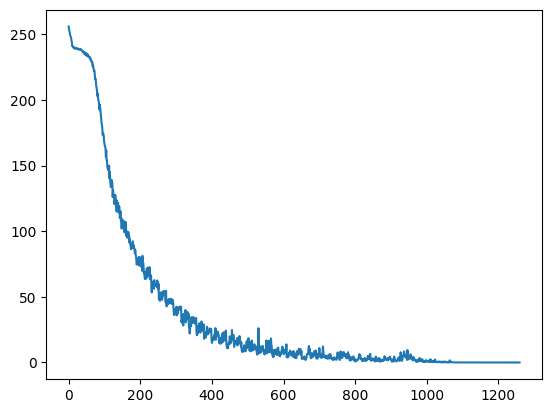

In [54]:
plt.plot(loss_over_time)

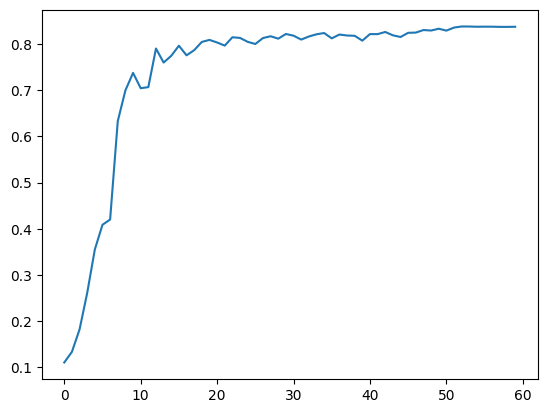

In [55]:
plt.plot(val_accuracy_over_time)

<AxesSubplot:>

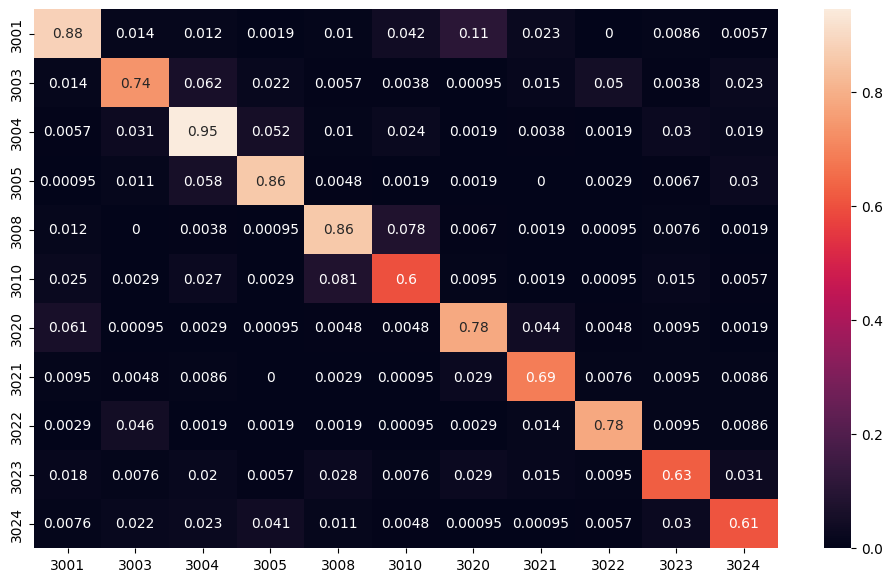

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def get_brick_name(class_encoding: int):
        for brick, enc_class in dataset.encoding.items():
                if enc_class == class_encoding:
                        return brick

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [get_brick_name(i) for i in set(y_true)],
                     columns = [get_brick_name(j) for j in set(y_true)])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [57]:
import torchvision
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64)), 
                                               transforms.Grayscale(num_output_channels=3)])

In [59]:
from torch import argmax

cap = cv2.VideoCapture(1) #Set the webcam
def Webcam_720p():
    cap.set(3,640)
    cap.set(4,640)

Webcam_720p()
fps = 0
show_score = 0
show_res = 'Nothing'
sequence = 0
while True:
    ret, frame = cap.read() #Capture each frame
    if fps == 4:
        image        = frame[160: 480, 160: 480]
        image_data   = data_transforms(image)
        cv2.imshow('test', image)
        net.eval()
        dataloader = DataLoader([image_data], batch_size=1, shuffle=True)
        data = next(iter(dataloader))
        prediction = net(data)
        result = argmax(prediction)
        fps = 0
        if result >= 0.5:
            for piece, encoded_class in dataset.encoding.items():
                if result.item() == encoded_class:
                    piece_data = dataset.brick_info.loc[piece]
                    show_res = piece_data['name']
        else:
            show_res = "Nothing"
        
    fps += 1
    cv2.putText(frame, '%s' %(show_res), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    # cv2.putText(frame, '(score = %.5f)' %(show_score), (950,300), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.rectangle(frame,(160, 480), (480, 160), (250,0,0), 2)
    cv2.imshow("LEGO DETECTOR", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyWindow("LEGO DETECTOR")

: 